In [1]:
import pandas as pd
import mlflow

In [2]:
df = pd.read_csv('../Dataset/retail_sales.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

D:\temp\ipykernel_26336\4183834281.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


In [4]:
df.set_index('Date', inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52585 entries, 2015-01-01 00:00:00 to 2020-12-31 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   52585 non-null  float64
dtypes: float64(1)
memory usage: 821.6 KB


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=False)


In [33]:
train

,Sales
Date,
2015-01-01 00:00:00,0.157102
2015-01-01 01:00:00,0.128376
2015-01-01 02:00:00,0.171189
2015-01-01 03:00:00,0.175611
2015-01-01 04:00:00,0.204688
...,...
2019-10-19 15:00:00,0.693323
2019-10-19 16:00:00,0.683681
2019-10-19 17:00:00,0.672388


<Axes: title={'center': 'Retail Sales'}, xlabel='Date'>

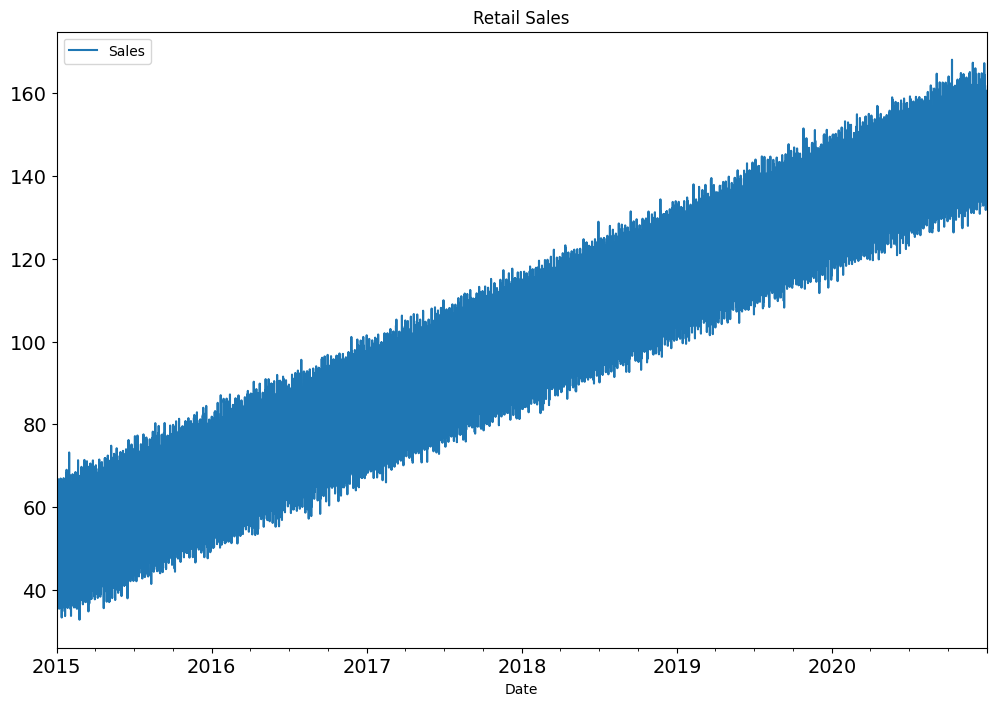

In [7]:
from matplotlib import pyplot as plt

df.plot(title='Retail Sales', figsize=(12, 8), fontsize=14)


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Sales'] = scaler.fit_transform(df[['Sales']])

In [9]:
import numpy as np

def create_sequences(data, index, window_size):
    X, y, timestamps = [], [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
        timestamps.append(index[i + window_size])
    return np.array(X), np.array(y), np.array(timestamps)

window_size=24

train_X, train_y, train_ts = create_sequences(train['Sales'].values, train.index, window_size)
test_X, test_y, test_ts = create_sequences(test['Sales'].values, test.index, window_size)




In [10]:
X_train, X_test = train_X, test_X
y_train, y_test = train_y, test_y
ts_train, ts_test = train_ts, test_ts

In [11]:
import numpy as np

def save_preprocessed_data(filepath, X_train, y_train, ts_train, X_test, y_test, ts_test):
    np.savez(filepath,
             X_train=X_train,
             y_train=y_train,
             ts_train=ts_train,
             X_test=X_test,
             y_test=y_test,
             ts_test=ts_test)


In [12]:
save_preprocessed_data("retail_sales_preprocessed.npz", 
                       X_train, y_train, ts_train, 
                       X_test, y_test, ts_test)


In [13]:
def load_preprocessed_data(filepath):
    data = np.load(filepath, allow_pickle=True)
    return (data['X_train'], data['y_train'], data['ts_train'],
            data['X_test'], data['y_test'], data['ts_test'])


In [14]:
X_train, y_train, ts_train, X_test, y_test, ts_test = load_preprocessed_data("retail_sales_preprocessed.npz")


In [15]:
print("Train lengths")
print(f"train = {len(train)}")
print(f"X_train = {len(X_train)}")

print("Test length")
print(f"test = {len(test)}")
print(f"X_test = {len(X_test)}")

Train lengths
train = 42068
X_train = 42044
Test length
test = 10517
X_test = 10493


# MLFLOW

# Tensorflow

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


g:\Rahul's Projects\Timeseries-MLops\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1314/1314 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 126.3450 - val_loss: 7.2118
Epoch 2/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 13.6499 - val_loss: 8.9621
Epoch 3/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.8715 - val_loss: 7.5108
Epoch 4/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 6.9017 - val_loss: 9.1244
Epoch 5/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.8734 - val_loss: 6.4051
Epoch 6/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.6454 - val_loss: 10.3301
Epoch 7/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.6626 - val_loss: 6.2570
Epoch 8/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.5035 - val_loss: 6.7869
Epoch 9/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.3197 - val_loss: 6.1565
Epoch 10/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 6.4831 - val_loss: 6.6347


In [43]:
# Predict
y_pred = model.predict(X_test)

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


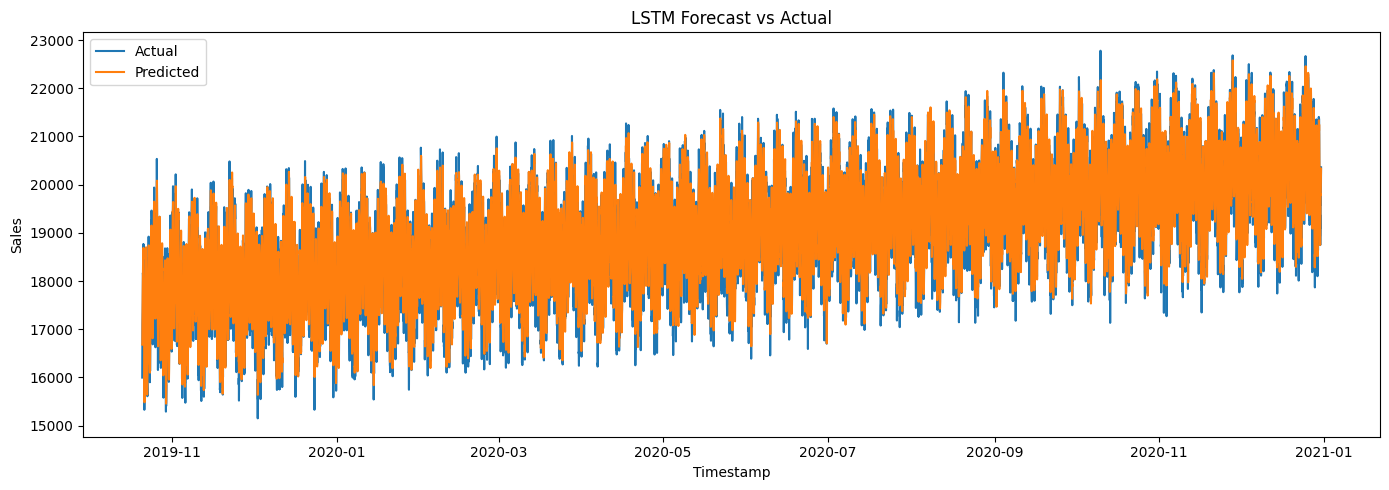

In [44]:
# Inverse scale (optional)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot with datetime index
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(ts_test, y_test_rescaled, label='Actual')
plt.plot(ts_test, y_pred_rescaled, label='Predicted')
plt.xlabel("Timestamp")
plt.ylabel("Sales")
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
output = pd.DataFrame({
    'Actual': y_test_rescaled.flatten(),
    'Predicted': y_pred_rescaled.flatten()
})

In [17]:
output

,Actual,Predicted
0,128.459712,130.218430
1,133.615522,130.814133
2,136.702109,132.837311
3,138.046735,135.212311
4,136.735653,137.046738
...,...,...
10508,140.946779,142.692886
10509,145.561324,143.529724
10510,144.484071,145.358932
10511,147.890291,146.325912


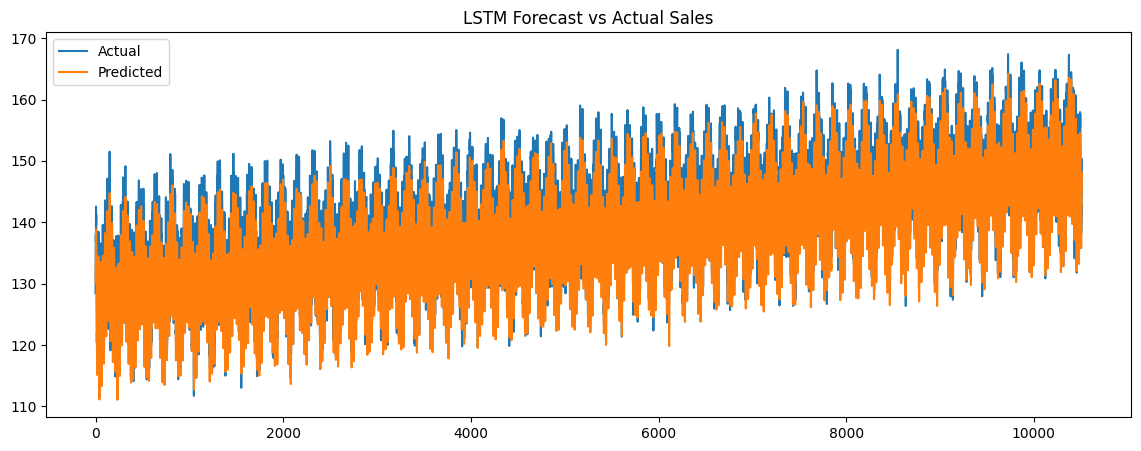

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Forecast vs Actual Sales")
plt.show()
